In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                '/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
print('rows, columns:', df.shape)
df.head()

rows, columns: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Combining transformers and estimators in a pipeline

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


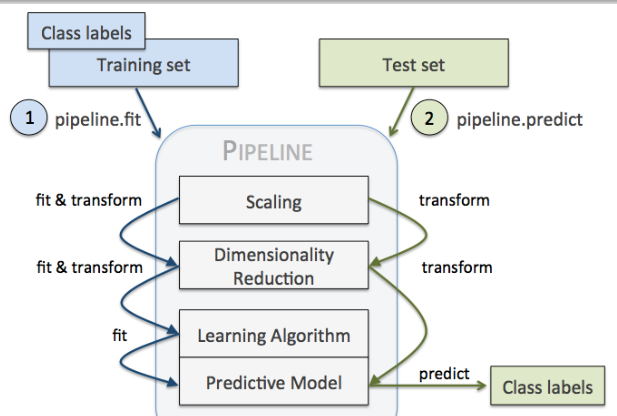

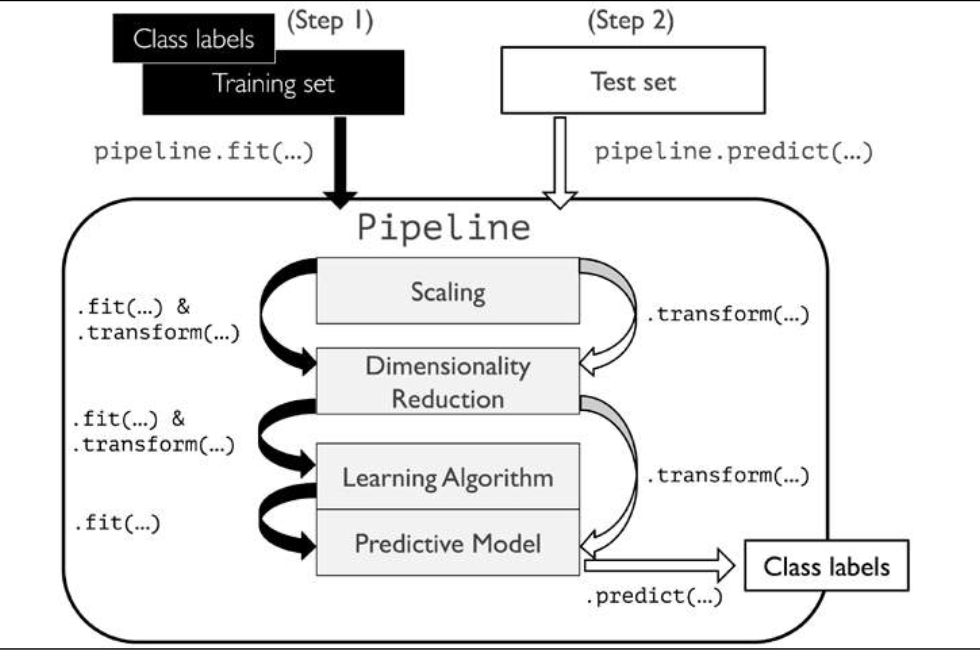

## Using k-fold cross-validation to assess model performance

### The holdout method

A classic and popular approach for estimating the generalization performance of
machine learning models is holdout cross-validation. Using the holdout method, we
split our initial dataset into separate training and test datasets—the former is used
for model training, and the latter is used to estimate its generalization performance.
However, in typical machine learning applications, we are also interested in tuning
and comparing different parameter settings to further improve the performance for
making predictions on unseen data. This process is called model selection, with
the name referring to a given classification problem for which we want to select
the optimal values of tuning parameters (also called hyperparameters). However, if
we reuse the same test dataset over and over again during model selection, it will
become part of our training data and thus the model will be more likely to overfit.
Despite this issue, many people still use the test dataset for model selection, which
is not a good machine learning practice.
A better way of using the holdout method for model selection is to separate the
data into three parts: a training dataset, a validation dataset, and a test dataset.
The training dataset is used to fit the different models, and the performance on the
validation dataset is then used for the model selection. The advantage of having
a test dataset that the model hasn't seen before during the training and model
selection steps is that we can obtain a less biased estimate of its ability to generalize
to new data. The following figure illustrates the concept of holdout cross-validation,
where we use a validation dataset to repeatedly evaluate the performance of the
model after training using different hyperparameter values. Once we are satisfied
with the tuning of hyperparameter values, we estimate the model's generalization
performance on the test dataset:

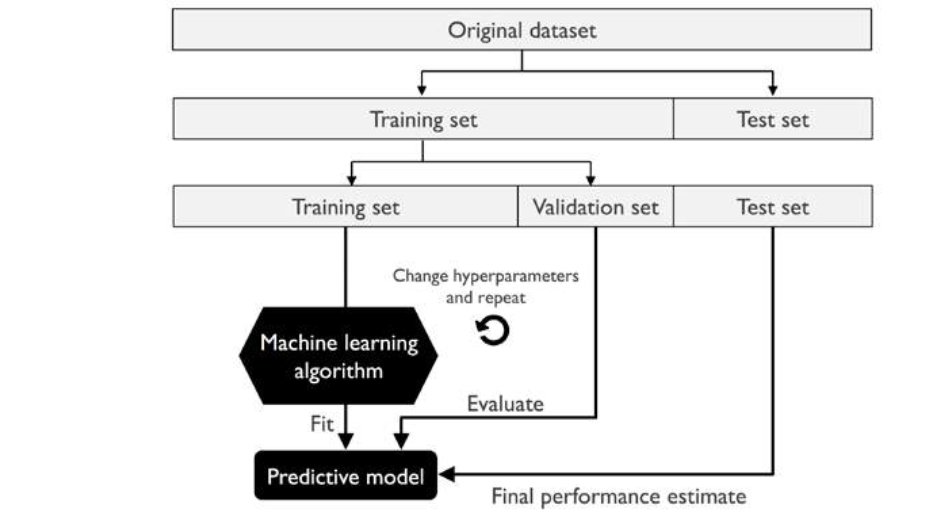

# K-fold cross-validation

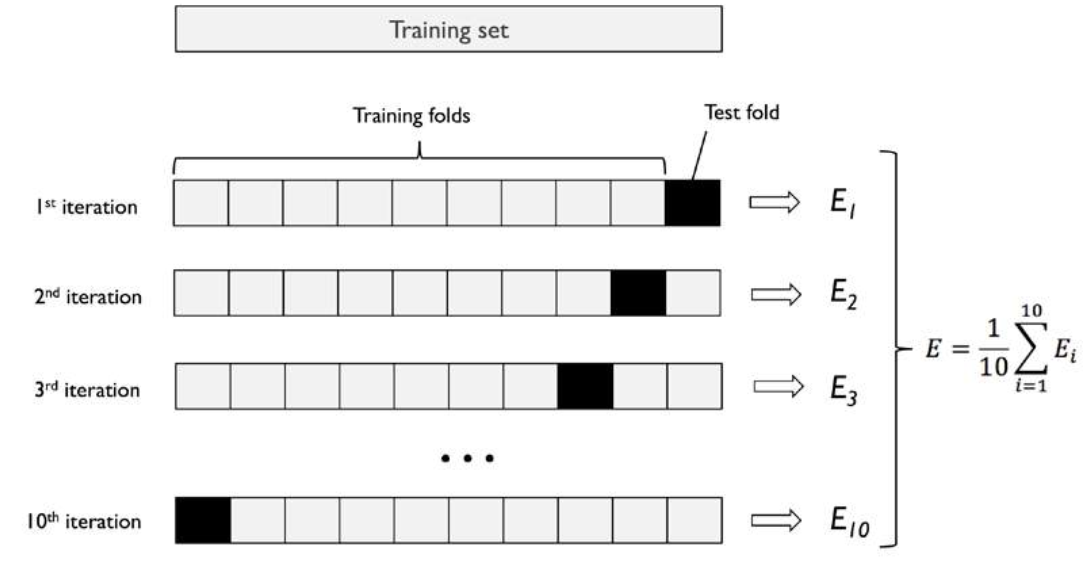

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [8]:
# number of folds via the n_splits parameter
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

In [11]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.913
Fold:  2, Class dist.: [256 153], Acc: 0.978
Fold:  3, Class dist.: [256 153], Acc: 0.978
Fold:  4, Class dist.: [256 153], Acc: 0.913
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.978
Fold:  7, Class dist.: [257 153], Acc: 0.933
Fold:  8, Class dist.: [257 153], Acc: 0.956
Fold:  9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.91304348 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


# Tuning hyperparameters via grid search

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},{'svc__C': param_range,'svc__gamma': param_range,'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9781159420289856
{'svc__C': 0.1, 'svc__kernel': 'linear'}


## Algorithm selection with nested crossvalidation

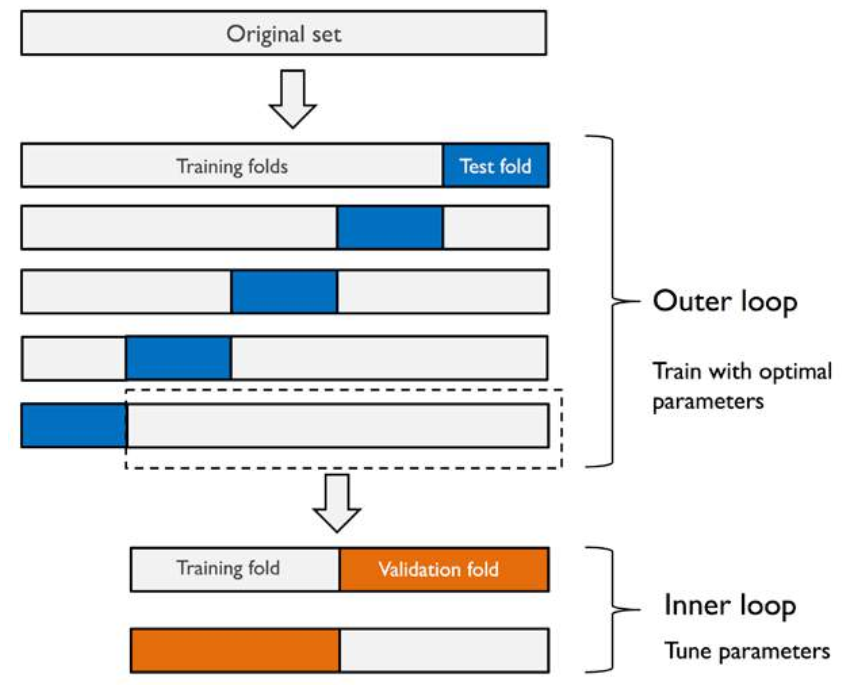

In [15]:
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=2)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [16]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),param_grid=[{'max_depth': [1, 2, 3,4, 5, 6,7, None]}],scoring='accuracy',cv=2)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
np.std(scores)))

CV accuracy: 0.921 +/- 0.029


# Looking at different performance evaluation metrics

## Reading a confusion matrix

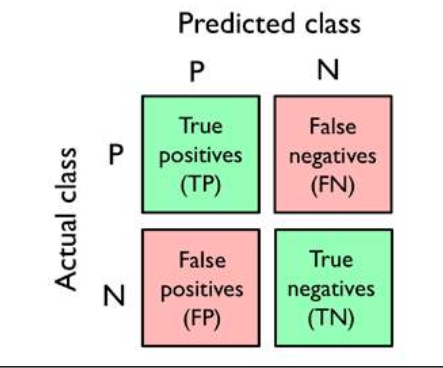

In [17]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [19]:
import matplotlib.pyplot as plt 

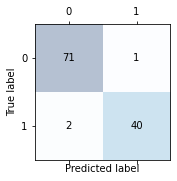

In [20]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,s=confmat[i, j],va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()